In [1]:
import re 
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV,
StratifiedKFold, learning_curve, cross_val_predict, cross_validate,
permutation_test_score, validation_curve, StratifiedKFold, RandomizedSearchCV)

from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report)

warnings.filterwarnings('ignore') 
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [2]:
df = pd.read_csv('Enterprise_GenAI_Adoption_Impact.csv', engine='pyarrow')
df.head()

,Company Name,Industry,Country,GenAI Tool,Adoption Year,Number of Employees Impacted,New Roles Created,Training Hours Provided,Productivity Change (%),Employee Sentiment
0,Davis LLC Pvt. Ltd.,Healthcare,USA,Mixtral,2022,5277,8,657,25.2,"Productivity increased, but there's anxiety ab..."
1,"Roberts, Holland and Bradshaw Pvt. Ltd.",Telecom,South Africa,Claude,2023,18762,17,23021,27.5,"We now finish tasks faster, but some older emp..."
2,Roman Inc Pvt. Ltd.,Advertising,India,Gemini,2023,11307,17,4680,11.5,"Productivity increased, but there's anxiety ab..."
3,Nguyen-Strickland Pvt. Ltd.,Technology,UK,Groq,2023,18834,12,1750,7.0,"AI helped me reduce repetitive tasks, but lear..."
4,Jackson PLC Pvt. Ltd.,Hospitality,UK,LLaMA,2024,8364,22,3925,2.5,"Job roles have shifted a lot, which is both go..."


In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.rename(columns={'company name':'company_name', 'genai tool':'gen_ai_tool', 
                   'adoption year':'adoption_year', 'number of employees impacted':'num_employees_impacted',
                   'new roles created':'new_roles_created',	'training hours provided':'training_hours_provided',
                   'productivity change (%)':'productivity_change_percentage', 'employee sentiment':'employee_sentiment'},
          inplace=True)

In [5]:
df.head()

,company_name,industry,country,gen_ai_tool,adoption_year,num_employees_impacted,new_roles_created,training_hours_provided,productivity_change_percentage,employee_sentiment
0,Davis LLC Pvt. Ltd.,Healthcare,USA,Mixtral,2022,5277,8,657,25.2,"Productivity increased, but there's anxiety ab..."
1,"Roberts, Holland and Bradshaw Pvt. Ltd.",Telecom,South Africa,Claude,2023,18762,17,23021,27.5,"We now finish tasks faster, but some older emp..."
2,Roman Inc Pvt. Ltd.,Advertising,India,Gemini,2023,11307,17,4680,11.5,"Productivity increased, but there's anxiety ab..."
3,Nguyen-Strickland Pvt. Ltd.,Technology,UK,Groq,2023,18834,12,1750,7.0,"AI helped me reduce repetitive tasks, but lear..."
4,Jackson PLC Pvt. Ltd.,Hospitality,UK,LLaMA,2024,8364,22,3925,2.5,"Job roles have shifted a lot, which is both go..."


In [6]:
df['gen_ai_tool'] = df['gen_ai_tool'].str.replace('LLaMA', 'Llama')

In [7]:
df['gen_ai_tool'].value_counts()

gen_ai_tool
Gemini     16885
Groq       16748
Llama      16676
Mixtral    16667
ChatGPT    16663
Claude     16361
Name: count, dtype: int64

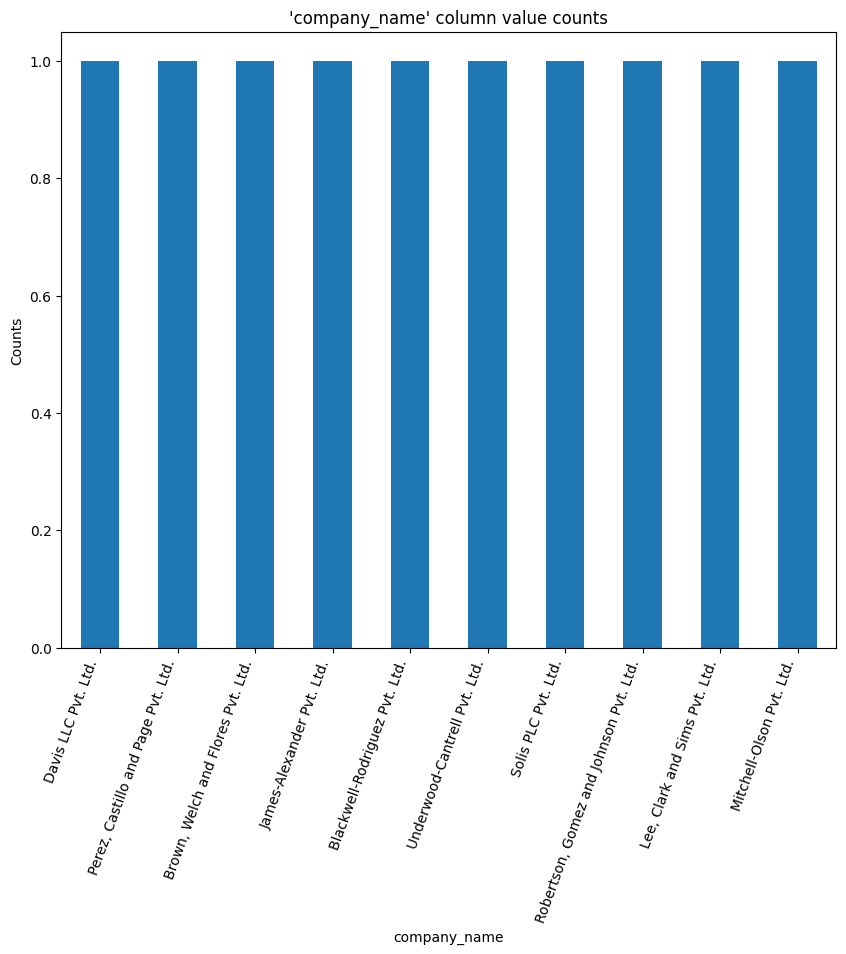

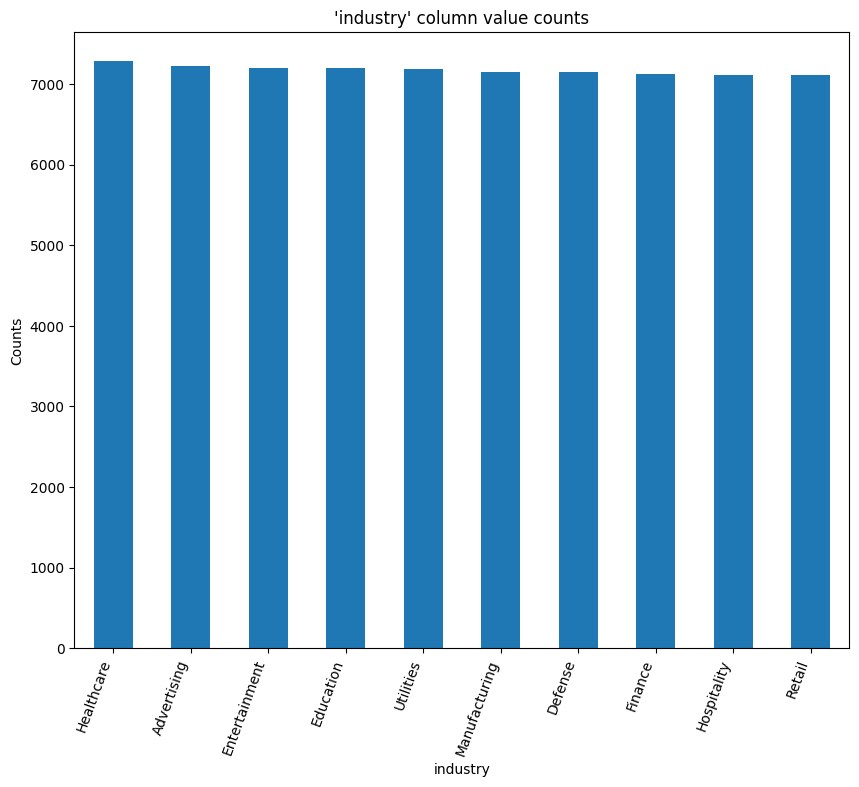

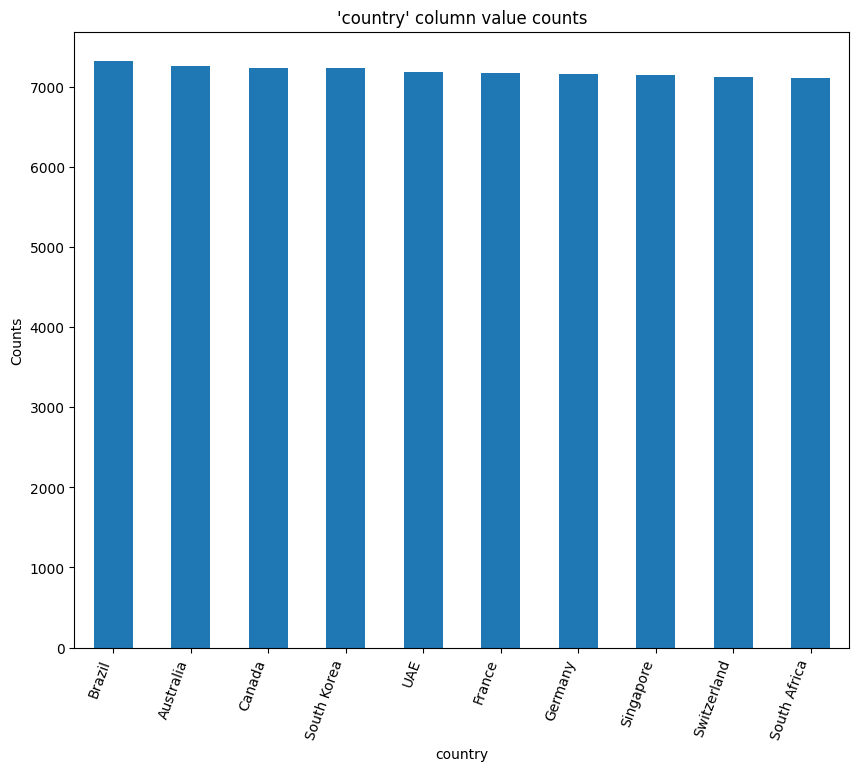

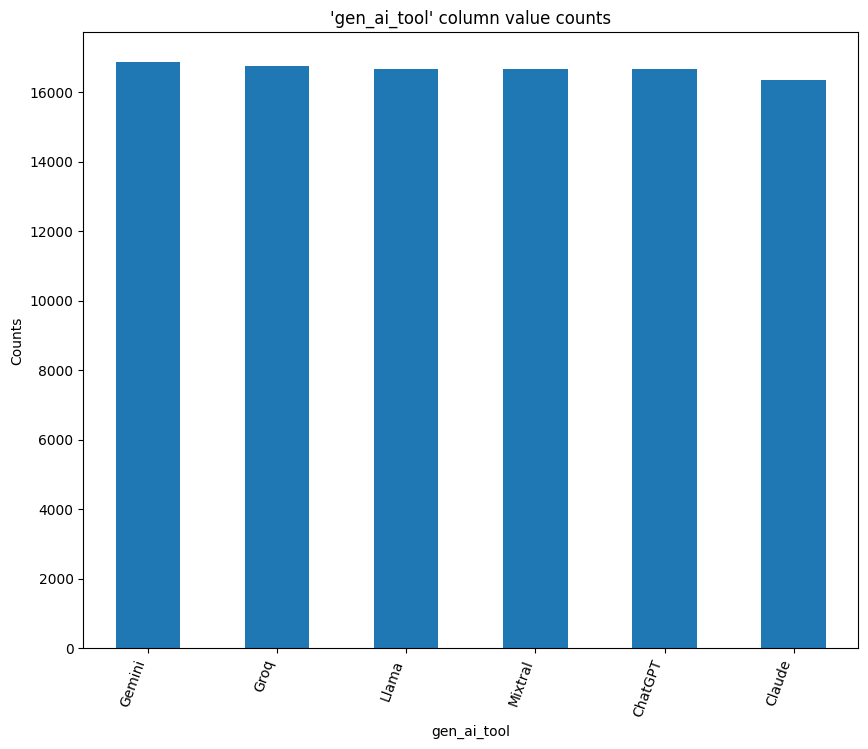

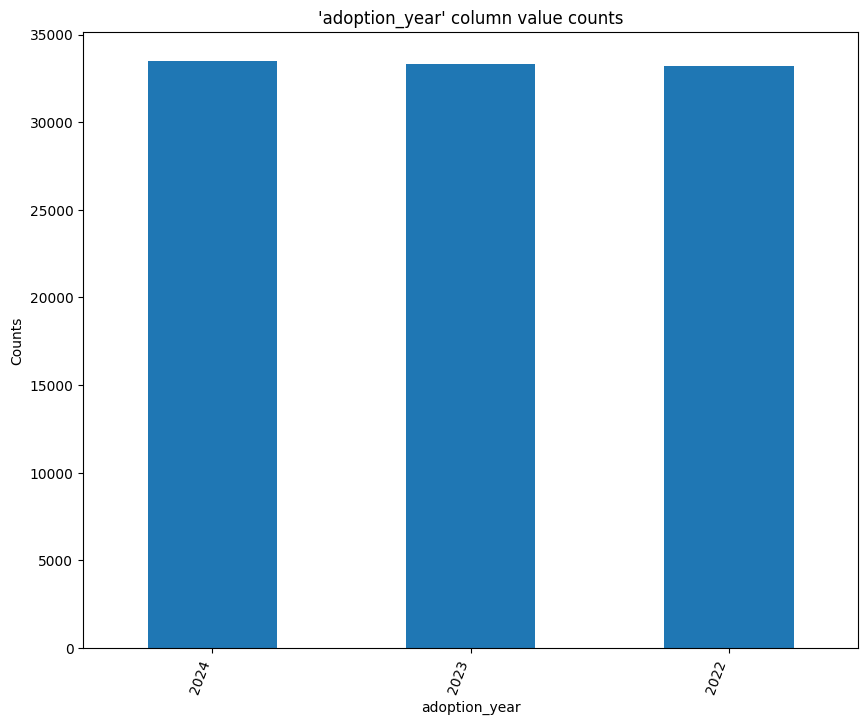

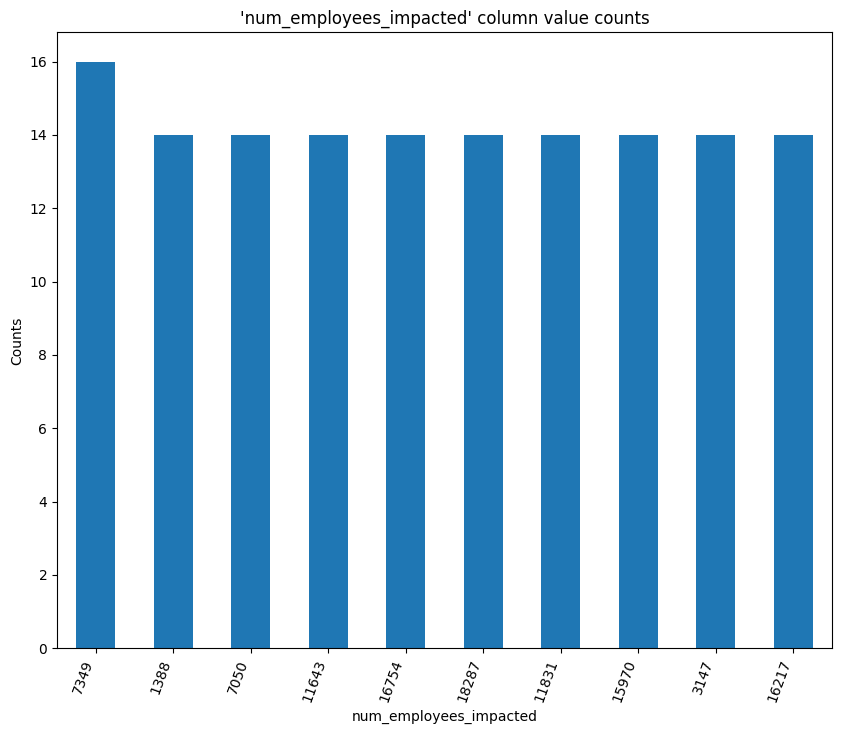

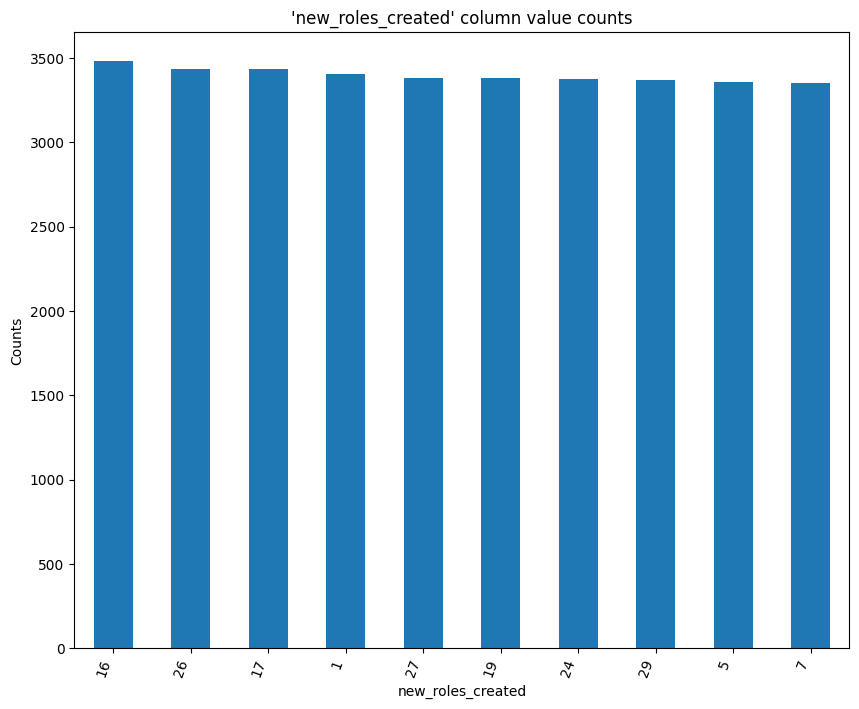

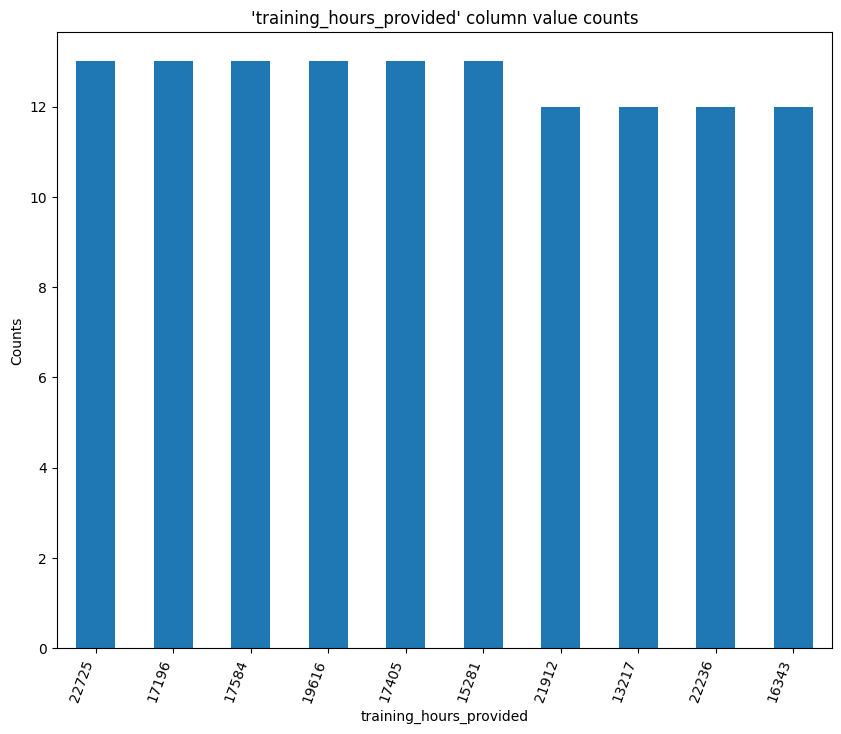

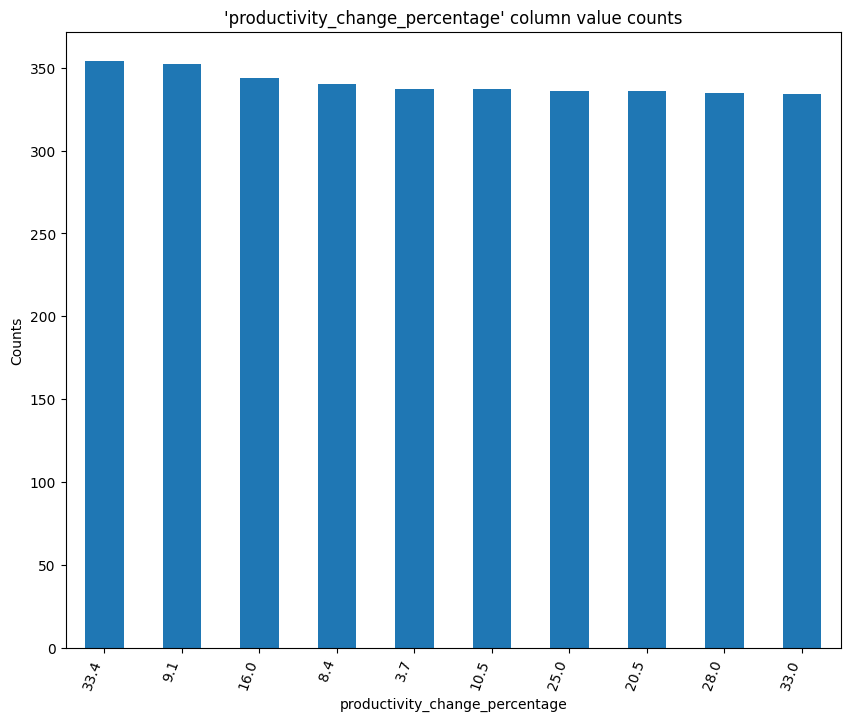

In [8]:
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = ['company_name', 'industry', 'country', 'gen_ai_tool', 'adoption_year', 'num_employees_impacted',
           'new_roles_created', 'training_hours_provided', 'productivity_change_percentage']

for column in columns:
    eda_plot(column)

In [21]:
df.columns

Index(['company_name', 'industry', 'country', 'gen_ai_tool', 'adoption_year', 'num_employees_impacted', 'new_roles_created', 'training_hours_provided', 'productivity_change_percentage', 'employee_sentiment'], dtype='object')

In [9]:
df['employee_sentiment']

0        Productivity increased, but there's anxiety ab...
1        We now finish tasks faster, but some older emp...
2        Productivity increased, but there's anxiety ab...
3        AI helped me reduce repetitive tasks, but lear...
4        Job roles have shifted a lot, which is both go...
                               ...                        
99995    AI helped me reduce repetitive tasks, but lear...
99996    Collaboration improved; documentation and meet...
99997    Our workflows have improved drastically with g...
99998    We now finish tasks faster, but some older emp...
99999    AI helped me reduce repetitive tasks, but lear...
Name: employee_sentiment, Length: 100000, dtype: object

In [10]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Example 1: Basic Text Feature Extraction
print("=== Example 1: Basic Text Feature Extraction ===")

def extract_text_features(text):
    """Extract basic features from text"""
    features = {}
    
    # Basic text statistics
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    features['char_count'] = len(text.replace(' ', ''))
    features['avg_word_length'] = np.mean([len(word) for word in text.split()])
    
    # Punctuation features
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['comma_count'] = text.count(',')
    features['period_count'] = text.count('.')
    
    # Case features
    features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / len(text) if text else 0
    features['has_caps'] = any(c.isupper() for c in text)
    
    return features

# Sample texts
texts = df['employee_sentiment']

# Extract features
text_features = [extract_text_features(text) for text in texts]

# Vectorize using DictVectorizer
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(text_features)

print("Feature names:", vectorizer.feature_names_)
print("Feature matrix shape:", X.shape)
print("\nFeature matrix (dense):")
print(X.toarray())

print("\n" + "="*60)

# Example 2: N-gram Features with DictVectorizer
print("=== Example 2: N-gram Features ===")

def extract_ngram_features(text, n=2):
    """Extract n-gram features from text"""
    features = {}
    words = text.lower().split()
    
    # Character n-grams
    char_ngrams = [text[i:i+n] for i in range(len(text)-n+1)]
    for ngram in char_ngrams:
        features[f'char_{ngram}'] = features.get(f'char_{ngram}', 0) + 1
    
    # Word n-grams
    word_ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    for ngram in word_ngrams:
        features[f'word_{ngram}'] = features.get(f'word_{ngram}', 0) + 1
    
    return features

# Extract n-gram features
ngram_features = [extract_ngram_features(text) for text in texts]

# Vectorize
ngram_vectorizer = DictVectorizer()
X_ngram = ngram_vectorizer.fit_transform(ngram_features)

print("N-gram feature count:", len(ngram_vectorizer.feature_names_))
print("Sample features:", ngram_vectorizer.feature_names_[:10])

print("\n" + "="*60)

# Example 3: Sentiment Analysis with Custom Features
print("=== Example 3: Sentiment Analysis Pipeline ===")

# Sample dataset
sentiment_data = df['employee_sentiment']

def extract_sentiment_features(text):
    """Extract features relevant for sentiment analysis"""
    features = {}
    text_lower = text.lower()
    
    # Basic features
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    
    # Sentiment indicators
    positive_words = ['love', 'amazing', 'fantastic', 'brilliant', 'incredible', 'outstanding', 'good', 'great']
    negative_words = ['hate', 'worst', 'terrible', 'boring', 'bad', 'awful', 'waste']
    
    features['positive_word_count'] = sum(1 for word in positive_words if word in text_lower)
    features['negative_word_count'] = sum(1 for word in negative_words if word in text_lower)
    
    # Punctuation sentiment
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    
    # Intensity words
    intensity_words = ['very', 'really', 'extremely', 'absolutely', 'completely']
    features['intensity_count'] = sum(1 for word in intensity_words if word in text_lower)
    
    # Word presence (binary features)
    important_words = ['love', 'hate', 'good', 'bad', 'amazing', 'terrible', 'great', 'worst']
    for word in important_words:
        features[f'has_{word}'] = word in text_lower
    
    return features

# Prepare data
texts = [item[0] for item in sentiment_data]
labels = [item[1] for item in sentiment_data]

# Extract features
features = [extract_sentiment_features(text) for text in texts]

# Vectorize
sentiment_vectorizer = DictVectorizer()
X_sentiment = sentiment_vectorizer.fit_transform(features)

# Train a simple classifier
X_train, X_test, y_train, y_test = train_test_split(
    X_sentiment, labels, test_size=0.3, random_state=42
)

# Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)
nb_predictions_train = nb_classifier.predict(X_train)

print("Naive Bayes Accuracy Test Set:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Accuracy Train Set:", accuracy_score(y_train, nb_predictions_train))

# Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_predictions_train = lr_classifier.predict(X_train)

print("Logistic Regression Accuracy Test Set:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression Accuracy Train Set:", accuracy_score(y_train, lr_predictions_train))

print("\nFeature names (first 10):", sentiment_vectorizer.feature_names_[:10])

print("\n" + "="*60)

# Example 4: Combining Multiple Feature Types
print("=== Example 4: Combined Feature Engineering ===")

def extract_comprehensive_features(text):
    """Extract comprehensive features combining multiple approaches"""
    features = {}
    text_lower = text.lower()
    words = text.split()
    
    # Basic statistics
    features['length'] = len(text)
    features['word_count'] = len(words)
    features['unique_word_count'] = len(set(words))
    features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0
    
    # Readability features
    features['sentence_count'] = text.count('.') + text.count('!') + text.count('?')
    features['avg_sentence_length'] = len(words) / max(1, features['sentence_count'])
    
    # POS-like features (simple heuristics)
    # Articles
    articles = ['a', 'an', 'the']
    features['article_count'] = sum(1 for word in words if word.lower() in articles)
    
    # Pronouns
    pronouns = ['i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them']
    features['pronoun_count'] = sum(1 for word in words if word.lower() in pronouns)
    
    # Modal verbs
    modals = ['can', 'could', 'may', 'might', 'will', 'would', 'shall', 'should', 'must']
    features['modal_count'] = sum(1 for word in words if word.lower() in modals)
    
    # Word endings (simple morphology)
    ing_words = sum(1 for word in words if word.lower().endswith('ing'))
    ed_words = sum(1 for word in words if word.lower().endswith('ed'))
    ly_words = sum(1 for word in words if word.lower().endswith('ly'))
    
    features['ing_ratio'] = ing_words / len(words) if words else 0
    features['ed_ratio'] = ed_words / len(words) if words else 0
    features['ly_ratio'] = ly_words / len(words) if words else 0
    
    # Special characters
    features['digit_count'] = sum(1 for c in text if c.isdigit())
    features['special_char_count'] = sum(1 for c in text if not c.isalnum() and not c.isspace())
    
    return features

# Apply comprehensive feature extraction
comprehensive_features = [extract_comprehensive_features(text) for text in texts]

# Vectorize
comp_vectorizer = DictVectorizer()
X_comp = comp_vectorizer.fit_transform(comprehensive_features)

print("Comprehensive feature count:", X_comp.shape[1])
print("Sample comprehensive features:")
for i, name in enumerate(comp_vectorizer.feature_names_[:15]):
    print(f"  {name}")

# Train with comprehensive features
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(
    X_comp, labels, test_size=0.3, random_state=42
)

lr_comp = LogisticRegression(random_state=42)
lr_comp.fit(X_train_comp, y_train_comp)
comp_predictions = lr_comp.predict(X_test_comp)
comp_predictions_train = lr_comp.predict(X_train_comp)

print(f"\nComprehensive Features Accuracy Test set:  {accuracy_score(y_test_comp, comp_predictions):.3f}")
print(f"\nComprehensive Features Accuracy Train set: {accuracy_score(y_train_comp, comp_predictions_train):.3f}")

print("\n" + "="*60)

# Example 5: Handling Sparse Features and Feature Selection
print("=== Example 5: Feature Analysis and Selection ===")

# Analyze feature importance
feature_names = comp_vectorizer.feature_names_
feature_importance = np.abs(lr_comp.coef_[0])  # For binary classification

# Create feature importance dataframe
feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_df.head(10))

# Demonstrate sparse matrix properties
print(f"\nSparse matrix properties:")
print(f"Shape: {X_comp.shape}")
print(f"Non-zero elements: {X_comp.nnz}")
print(f"Sparsity: {(1 - X_comp.nnz / (X_comp.shape[0] * X_comp.shape[1])) * 100:.2f}%")

# Example of getting feature names and values for a specific instance
print(f"\nFeatures for first text: '{texts[0]}'")
instance_features = comprehensive_features[0]
for feature, value in sorted(instance_features.items()):
    if value > 0:  # Only show non-zero features
        print(f"  {feature}: {value}")

print("\n" + "="*60)

# Example 6: Real-world Usage Pattern
print("=== Example 6: Production Pipeline Example ===")

class TextFeatureExtractor:
    """Production-ready text feature extractor using DictVectorizer"""
    
    def __init__(self):
        self.vectorizer = DictVectorizer()
        self.is_fitted = False
    
    def extract_features(self, text):
        """Extract features from a single text"""
        features = {}
        text_lower = text.lower()
        words = text.split()
        
        # Core features
        features['length'] = len(text)
        features['word_count'] = len(words)
        features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0
        
        # Sentiment features
        positive_words = ['good', 'great', 'excellent', 'amazing', 'love']
        negative_words = ['bad', 'terrible', 'hate', 'awful', 'worst']
        
        features['positive_words'] = sum(1 for word in positive_words if word in text_lower)
        features['negative_words'] = sum(1 for word in negative_words if word in text_lower)
        features['exclamations'] = text.count('!')
        
        return features
    
    def fit_transform(self, texts):
        """Fit vectorizer and transform texts"""
        features_list = [self.extract_features(text) for text in texts]
        X = self.vectorizer.fit_transform(features_list)
        self.is_fitted = True
        return X
    
    def transform(self, texts):
        """Transform texts using fitted vectorizer"""
        if not self.is_fitted:
            raise ValueError("Extractor must be fitted first")
        
        if isinstance(texts, str):
            texts = [texts]
        
        features_list = [self.extract_features(text) for text in texts]
        return self.vectorizer.transform(features_list)
    
    def get_feature_names(self):
        """Get feature names"""
        return self.vectorizer.feature_names_

# Demonstrate usage
extractor = TextFeatureExtractor()

# Fit on training data
train_texts = [item[0] for item in sentiment_data[:7]]
X_train_pipeline = extractor.fit_transform(train_texts)

# Transform test data
test_texts = [item[0] for item in sentiment_data[7:]]
X_test_pipeline = extractor.transform(test_texts)

print("Pipeline feature names:", extractor.get_feature_names())
print("Training matrix shape:", X_train_pipeline.shape)
print("Test matrix shape:", X_test_pipeline.shape)

# Transform a single new text
new_text = "This is absolutely amazing and I love it!"
new_features = extractor.transform(new_text)
print(f"\nNew text features shape: {new_features.shape}")
print("New text feature values:", new_features.toarray())

print("\n=== Examples Complete ===")

=== Example 1: Basic Text Feature Extraction ===
Feature names: ['avg_word_length', 'char_count', 'comma_count', 'exclamation_count', 'has_caps', 'length', 'period_count', 'question_count', 'uppercase_ratio', 'word_count']
Feature matrix shape: (100000, 10)

Feature matrix (dense):
[[6.83333333e+00 8.20000000e+01 1.00000000e+00 ... 0.00000000e+00
  2.15053763e-02 1.20000000e+01]
 [4.90000000e+00 9.80000000e+01 1.00000000e+00 ... 0.00000000e+00
  3.41880342e-02 2.00000000e+01]
 [6.57142857e+00 9.20000000e+01 1.00000000e+00 ... 0.00000000e+00
  1.90476190e-02 1.40000000e+01]
 ...
 [6.50000000e+00 7.80000000e+01 0.00000000e+00 ... 0.00000000e+00
  4.49438202e-02 1.20000000e+01]
 [4.90000000e+00 9.80000000e+01 1.00000000e+00 ... 0.00000000e+00
  3.41880342e-02 2.00000000e+01]
 [5.86666667e+00 8.80000000e+01 1.00000000e+00 ... 0.00000000e+00
  2.94117647e-02 1.50000000e+01]]

=== Example 2: N-gram Features ===
N-gram feature count: 512
Sample features: ['char_ A', 'char_ C', 'char_ H', 'cha

In [11]:
# Basic TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Sample text data
documents = df['employee_sentiment']

# Basic TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# View feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()
print("Vocabulary:", feature_names)

# Convert to dense array and create DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print("\nTF-IDF Matrix:")
print(tfidf_df)

Vocabulary: ['about' 'adapted' 'ai' 'and' 'anxiety' 'are' 'behind' 'big' 'both' 'but'
 'cases' 'changed' 'clients' 'collaboration' 'communicate' 'concern'
 'curve' 'departments' 'discuss' 'documentation' 'drastically' 'due'
 'easier' 'efficient' 'employees' 'excited' 'exciting' 'expect' 'expected'
 'faster' 'feel' 'finish' 'fun' 'generative' 'good' 'halls' 'have'
 'helped' 'highlight' 'hosted' 'how' 'hr' 'improved' 'increased'
 'initially' 'internal' 'internally' 'is' 'it' 'job' 'learning' 'left'
 'lot' 'love' 'makes' 'management' 'managers' 'me' 'meetings' 'mixed'
 'monthly' 'more' 'my' 'new' 'newsletters' 'now' 'of' 'older' 'others'
 'our' 'overall' 'productivity' 'reduce' 'repetitive' 'replace'
 'responses' 'results' 'roles' 'rollout' 'rotations' 'scary' 'security'
 'shift' 'shifted' 'skeptical' 'smoother' 'some' 'soon' 'staff' 'steep'
 'struggling' 'tasks' 'team' 'than' 'that' 'the' 'there' 'to' 'town'
 'transition' 'uncertain' 'us' 'use' 'using' 'was' 'we' 'webinars'
 'weekly' 'we

In [12]:
# Advanced Preprocessing Options
# TF-IDF with comprehensive preprocessing
vectorizer_advanced = TfidfVectorizer(
    lowercase=True,           # Convert to lowercase
    stop_words='english',     # Remove English stop words
    max_features=1000,        # Limit vocabulary size
    min_df=2,                 # Ignore terms in less than 2 documents
    max_df=0.8,               # Ignore terms in more than 80% of documents
    ngram_range=(1, 2),       # Use unigrams and bigrams
    strip_accents='ascii',    # Remove accents
    token_pattern=r'\b[a-zA-Z]{2,}\b'  # Only alphabetic tokens, min 2 chars
)

# Larger sample dataset
texts = df['employee_sentiment']

tfidf_advanced = vectorizer_advanced.fit_transform(texts)
print("Advanced TF-IDF shape:", tfidf_advanced.shape)
print("Features:", vectorizer_advanced.get_feature_names_out()[:20])

Advanced TF-IDF shape: (100000, 259)
Features: ['adapted' 'adapted faster' 'ai' 'ai changed' 'ai clients'
 'ai departments' 'ai helped' 'ai hr' 'ai internal' 'ai job' 'ai managers'
 'ai monthly' 'ai overall' 'ai replace' 'ai rollout' 'ai team' 'ai use'
 'aiit' 'aiit makes' 'anxiety']


In [ ]:
# Document Similarity Analysis
from sklearn.metrics.pairwise import cosine_similarity

# Larger sample dataset
texts = df['employee_sentiment'] 

# Calculate document similarities
similarity_matrix = cosine_similarity(tfidf_advanced)

# Create similarity DataFrame
similarity_df = pd.DataFrame(
    similarity_matrix, 
    index=[f"Doc_{i}" for i in range(len(texts))],
    columns=[f"Doc_{i}" for i in range(len(texts))]
)

print("\nDocument Similarity Matrix:")
print(similarity_df.round(3))

# Find most similar documents
def find_most_similar(doc_index, similarity_matrix, texts):
    similarities = similarity_matrix[doc_index]
    # Exclude self-similarity
    similarities[doc_index] = -1
    most_similar_idx = np.argmax(similarities)
    
    print(f"\nDocument {doc_index}: '{texts[doc_index]}'")
    print(f"Most similar to Document {most_similar_idx}: '{texts[most_similar_idx]}'")
    print(f"Similarity score: {similarities[most_similar_idx]:.3f}")

find_most_similar(0, similarity_matrix, texts)

In [13]:
len(df['employee_sentiment'])

100000

In [19]:
# Text Classification Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Sample labels (1: positive, 0: negative)
import random
sample_labels = [1] * 50000 + [0] * 50000
random.shuffle(sample_labels)  # Randomly shuffle the order

# Use your actual data here:
texts_classification = df['employee_sentiment']  # Replace with df['employee_sentiment']
labels = sample_labels  # Replace with your actual labels

# Ensure we have both texts and labels
print(f"Number of texts: {len(texts_classification)}")
print(f"Number of labels: {len(labels)}")

# Split data - need to provide both X and y
X_train, X_test, y_train, y_test = train_test_split(
    texts_classification, labels,  # Both features and labels needed
    test_size=0.3, 
    random_state=42,
    stratify=labels  # Ensure balanced split
)

# Create pipeline with TF-IDF and ONE classifier (not two)
# Choose either MultinomialNB OR LogisticRegression
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        max_features=500
    )),
    ('classifier', MultinomialNB())
])

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        max_features=500
    )),
    ('classifier', LogisticRegression(random_state=42))
])

# Train and evaluate both models
print("=== Naive Bayes Results ===")
pipeline_nb.fit(X_train, y_train)
predictions_test_nb = pipeline_nb.predict(X_test)
predictions_train_nb = pipeline_nb.predict(X_train)

print("Test Set Results:")
print(classification_report(y_test, predictions_test_nb))
print("\nTraining Set Results:")
print(classification_report(y_train, predictions_train_nb))

print("\n=== Logistic Regression Results ===")
pipeline_lr.fit(X_train, y_train)
predictions_test_lr = pipeline_lr.predict(X_test)
predictions_train_lr = pipeline_lr.predict(X_train)

print("Test Set Results:")
print(classification_report(y_test, predictions_test_lr))
print("\nTraining Set Results:")
print(classification_report(y_train, predictions_train_lr))

# Test with new text
new_texts = ["This company is absolutely wonderful to work for", "I hate this boring job"]
new_predictions_nb = pipeline_nb.predict(new_texts)
new_predictions_lr = pipeline_lr.predict(new_texts)

print(f"\nPredictions for new texts:")
print(f"Naive Bayes: {new_predictions_nb}")
print(f"Logistic Regression: {new_predictions_lr}")

# Get prediction probabilities
prob_nb = pipeline_nb.predict_proba(new_texts)
prob_lr = pipeline_lr.predict_proba(new_texts)

print(f"\nPrediction probabilities:")
print(f"Naive Bayes: {prob_nb}")
print(f"Logistic Regression: {prob_lr}")

Number of texts: 100000
Number of labels: 100000
=== Naive Bayes Results ===
Test Set Results:
              precision    recall  f1-score   support

           0       0.50      0.48      0.49     15000
           1       0.50      0.52      0.51     15000

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000


Training Set Results:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50     35000
           1       0.51      0.53      0.52     35000

    accuracy                           0.51     70000
   macro avg       0.51      0.51      0.51     70000
weighted avg       0.51      0.51      0.51     70000


=== Logistic Regression Results ===
Test Set Results:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51     15000
           1       0.50      0.48      0.49     15000

    accur

In [25]:
# Text Classification Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Sample classification data
texts_classification = df['employee_sentiment']

# Sample labels (1: positive, 0: negative)
import random
labels = [1] * 50000 + [0] * 50000 # 1: positive, 0: negative 
random.shuffle(labels)  # Randomly shuffle the order
  
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    texts_classification, labels, test_size=0.3, random_state=42,
) # labels

# Create pipeline with TF-IDF and classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        max_features=500
    )),
    ('classifier', MultinomialNB())
])

# Train and evaluate
pipeline.fit(X_train, y_train)
predictions_test = pipeline.predict(X_test)
predictions_train = pipeline.predict(X_train)

print("Classification Results:\n")
print(classification_report(y_test, predictions_test),'\n')
print(classification_report(y_train, predictions_train))

# Test with new text
new_texts = ["This job is absolutely wonderful", "I hate this boring job"]
new_predictions = pipeline.predict(new_texts)
print(f"\nPredictions for new texts: {new_predictions}")

Classification Results:

              precision    recall  f1-score   support

           0       0.50      0.46      0.48     15093
           1       0.50      0.54      0.52     14907

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000
 

              precision    recall  f1-score   support

           0       0.51      0.47      0.49     34907
           1       0.51      0.55      0.53     35093

    accuracy                           0.51     70000
   macro avg       0.51      0.51      0.51     70000
weighted avg       0.51      0.51      0.51     70000


Predictions for new texts: [1 1]


In [26]:
# Feature Analysis and Interpretation
# Analyze most important features for each class
def analyze_features(vectorizer, classifier, feature_names, top_n=10):
    # Get feature coefficients (for Naive Bayes, these are log probabilities)
    feature_importance = classifier.feature_log_prob_
    
    for class_idx, class_name in enumerate(['Negative', 'Positive']):
        print(f"\nTop {top_n} features for {class_name} class:")
        
        # Get top features for this class
        top_indices = np.argsort(feature_importance[class_idx])[-top_n:][::-1]
        
        for idx in top_indices:
            feature = feature_names[idx]
            importance = feature_importance[class_idx][idx]
            print(f"  {feature}: {importance:.3f}")

# Extract components from pipeline
vectorizer_fitted = pipeline.named_steps['tfidf']
classifier_fitted = pipeline.named_steps['classifier']
feature_names = vectorizer_fitted.get_feature_names_out()

analyze_features(vectorizer_fitted, classifier_fitted, feature_names)


Top 10 features for Negative class:
  ai: -4.057
  job: -4.326
  faster: -4.500
  increased: -4.688
  improved: -4.723
  roles: -4.760
  feel: -4.767
  tasks: -4.794
  ai use: -4.822
  use: -4.822

Top 10 features for Positive class:
  ai: -4.056
  job: -4.325
  faster: -4.503
  improved: -4.689
  increased: -4.693
  feel: -4.749
  roles: -4.768
  tasks: -4.806
  ai use: -4.841
  use: -4.841


In [27]:
# Custom Preprocessing with TF-IDF
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def custom_preprocessor(text):
    """Custom preprocessing function"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def custom_tokenizer(text):
    """Custom tokenizer that splits on whitespace and filters short words"""
    tokens = text.split()
    return [token for token in tokens if len(token) > 2]

# TF-IDF with custom preprocessing
custom_vectorizer = TfidfVectorizer(
    preprocessor=custom_preprocessor,
    tokenizer=custom_tokenizer,
    stop_words=['the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for'],
    ngram_range=(1, 3),
    min_df=1,
    max_df=0.95
)

sample_texts = [
    "The quick brown fox jumps over the lazy dog!",
    "Machine learning algorithms are powerful tools.",
    "Natural language processing enables text analysis."
]

custom_tfidf = custom_vectorizer.fit_transform(sample_texts)
print("Custom TF-IDF shape:", custom_tfidf.shape)
print("Custom features:", custom_vectorizer.get_feature_names_out())

Custom TF-IDF shape: (3, 48)
Custom features: ['algorithms' 'algorithms are' 'algorithms are powerful' 'analysis' 'are'
 'are powerful' 'are powerful tools' 'brown' 'brown fox' 'brown fox jumps'
 'dog' 'enables' 'enables text' 'enables text analysis' 'fox' 'fox jumps'
 'fox jumps over' 'jumps' 'jumps over' 'jumps over lazy' 'language'
 'language processing' 'language processing enables' 'lazy' 'lazy dog'
 'learning' 'learning algorithms' 'learning algorithms are' 'machine'
 'machine learning' 'machine learning algorithms' 'natural'
 'natural language' 'natural language processing' 'over' 'over lazy'
 'over lazy dog' 'powerful' 'powerful tools' 'processing'
 'processing enables' 'processing enables text' 'quick' 'quick brown'
 'quick brown fox' 'text' 'text analysis' 'tools']


In [ ]:
# Saving and Loading TF-IDF Models
import joblib

# Save the fitted vectorizer
joblib.dump(vectorizer_advanced, 'tfidf_vectorizer.pkl')

# Load the vectorizer
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Transform new documents with loaded vectorizer
new_documents = ["This is a great tool for efficiency"]
new_tfidf = loaded_vectorizer.transform(new_documents)

print("New document TF-IDF shape:", new_tfidf.shape)
print("Non-zero features:", new_tfidf.nnz)